# The Solow model with human capital

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **model analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code from [lecture 5](https://numeconcopenhagen.netlify.com/lectures/Workflow_and_debugging).
> 1. Remember this [guide](https://www.markdownguide.org/basic-syntax/) on markdown and (a bit of) latex.
> 1. Turn on automatic numbering by clicking on the small icon on top of the table of contents in the left sidebar.
> 1. The `modelproject.py` file includes a function which could be used multiple times in this notebook.

Imports and set magics:

In [452]:
import numpy as np
from scipy import optimize
import sympy as sm
from sympy import Symbol
from sympy.solvers import solve
sm.init_printing(use_unicode=True) # for pretty printing
from IPython.display import display
import matplotlib.pyplot as plt # baseline modul

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import modelproject

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model description

We consider the **Solow model with human capital** where:

* $K_t$ is capital
* $L_t$ is labor
* $A_t$ is technology
* $H_t$ is human capital
* $Y_t = F(K_t,H_t,A_tL_t)$ is GDP

**GDP** is defined as

$ Y_{t}=K_{t}^{\alpha}H_{t}^{\varphi}(A_{t}L_{t})^{1-\alpha-\varphi} $

The **real interest rate** consists of

$ r_{t}=\alpha\left(\dfrac{K_{t}}{A_{t}L_{t}}\right)^{\alpha-1}\left(\dfrac{H_{t}}{A_{t}L_{t}}\right)^{\varphi} $

The **real wage** consists of

$ r_{t}=\alpha\left(\dfrac{K_{t}}{A_{t}L_{t}}\right)^{\alpha}\left(\dfrac{H_{t}}{A_{t}L_{t}}\right)^{\varphi}A_t $


**Saving** is a constant fraction of GDP

$ S_t = (s_H+s_K)Y_t,\,s\in(0,1) $

such that **capital accumulates** according to

$ K_{t+1}=s_{K}Y_t+(1-\delta)K_{t}=sF(K_{t},H_{t},A_{t}L_{t})+(1-\delta)K_{t}, \delta \in (0,1) $

and **human capital accumulates** according to

$ H_{t+1} = s_{H}Y_t+(1-\delta)H_t $

**Labour and technology accoumulates** as

$ L_{t+1} = (1+n)L_t $

$ A_{t+1} = (1+g)A_t $

The **transition equations** then becomes

$ \tilde{k}_{t+1}= \frac{1}{(1+n)(1+g)}[s_K\tilde{k}_{t}^{\alpha}\tilde{h}_{t}^{\varphi}+(1-\delta)\tilde{k}_{t}] $

$ \tilde{h}_{t+1}= \frac{1}{(1+n)(1+g)}[s_H\tilde{k}_{t}^{\alpha}\tilde{h}_{t}^{\varphi}+(1-\delta)\tilde{h}_{t}] $


where $\tilde{k}_{t}= \dfrac{K_t}{A_tL_t}$

# Steady state

## Analytical solution

We use **sympy** to find an analytical expression for the steady state, i.e. solve

$$ \tilde{k}^{\ast}= \frac{1}{(1+n)(1+g)}[s_K\tilde{k}^{\alpha\ast}\tilde{h}_{t}^{\varphi\ast}+(1-\delta)\tilde{k}^{\ast}] $$

and

$$ \tilde{h}^{\ast}= \frac{1}{(1+n)(1+g)}[s_K\tilde{k}^{\alpha\ast}\tilde{h}_{t}^{\varphi\ast}+(1-\delta)\tilde{h}^{\ast}] $$

First we define all **symbols**:

In [453]:
k = sm.symbols('k')
h = sm.symbols('h')
alpha = sm.symbols('alpha')
phi = sm.symbols('phi')
delta = sm.symbols('delta')
sh = sm.symbols('sh')
sk = sm.symbols('sk')
g = sm.symbols('g')
n = sm.symbols('n')

Then we define the **steady state equations**

In [454]:
ss1 = sm.Eq(k,(sk*k**alpha*h**phi+(1-delta)*k)/((1+n)*(1+g)))
ss2 = sm.Eq(h,(sh*k**alpha*h**phi+(1-delta)*h)/((1+n)*(1+g)))

and **solve** it

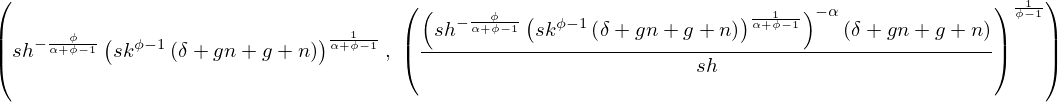

In [455]:
sss = sm.solve((ss1, ss2),(k,h))[0]
display(sss)

Which can be reduced to:

$$\tilde{k}^{\ast}=\left(\dfrac{s_K^{1-\varphi}s_H^{\varphi}}{n+g+\delta+ng}\right)^{\frac{1}{1-\alpha-\varphi}}$$

and

$$\tilde{h}^{\ast}=\left(\dfrac{s_K^{\alpha}s_H^{1-\alpha}}{n+g+\delta+ng}\right)^{\frac{1}{1-\alpha-\varphi}}$$

We turn the solution into a Python funciton

In [456]:
ss_func = sm.lambdify((sh,sk,g,n,alpha,phi,delta),sss)

## Numerical solution

We can re-write the equation for the steady state capital and human capital per capita as

\\[ 0 = \left(\dfrac{s_K^{1-\varphi}s_H^{\varphi}}{n+g+\delta+ng}\right)^{\frac{1}{1-\alpha-\varphi}} - \tilde{k}^{\ast} \\]

\\[ 0 = \left(\dfrac{s_K^{\alpha}s_H^{1-\alpha}}{n+g+\delta+ng}\right)^{\frac{1}{1-\alpha-\varphi}} - \tilde{h}^{\ast} \\]


whereby it clearly becomes a **root-finding problem**. Such a problem can be solved by a **bisection method**.

Define the model **parameters**:

In [457]:
sh = 0.1
sk = 0.1
g = 0.02
n = 0.01
alpha = 1/3
phi = 1/3
delta = 0.1

**Solve numerically** for the steady state:

In [458]:
def h_func(k,sh,sk,g,n,alpha,phi,delta,h):
    return 1/((1+n)*(1+g))*(sh*k**(alpha)*h**(phi)+(1-delta)*h)-h

def k_func(h,sh,sk,g,n,alpha,phi,delta,k):
    return 1/((1+n)*(1+g))*(sk*k**(alpha)*h**(phi)+(1-delta)*k)-k

obj1 = lambda x: [h_func(x[1],sh,sk,g,n,alpha,phi,delta,x[0]),k_func(x[0],sh,sk,g,n,alpha,phi,delta,x[1])]

sol= optimize.root(obj1,[1,1],method='broyden1')


In [459]:
analSolution = ss_func(sh,sk,g,n,alpha,phi,delta)
nummiSolution = sol.x

print(f'Analytical solution is: k* = {analSolution[0]:.3f}, h* = {analSolution[1]:.3f}')
print(f'Numerical solution is: k* = {nummiSolution[1]:.3f}, h* = {nummiSolution[0]:.3f}')


Analytical solution is: k* = 0.453, h* = 0.453
Numerical solution is: k* = 0.453, h* = 0.453


# Further analysis

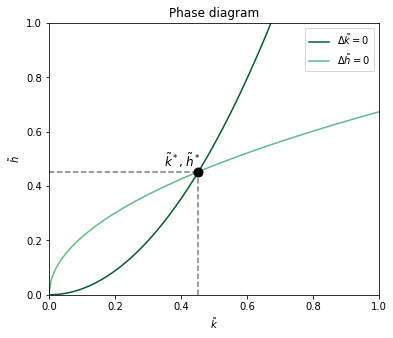

In [460]:
def solve_ss(sh,sk,g,n,alpha,phi,delta):

    # a. grids
    k_vec = np.linspace(1e-4,3,500)
    h_vec_DeltaK0 = np.empty(500)
    h_vec_DeltaH0  = np.empty(500)
    
    # b. solve for each m2 in grid
    for i,k in enumerate(k_vec):
        #Solve for delta_h=0
        
        # i. objective
        obj = lambda h: -h_func(k,sh,sk,g,n,alpha,phi,delta,h)

        # iii. optimizer
        result = optimize.root_scalar(obj,method='brentq',bracket=[1e-20,50])
        
        h_vec_DeltaH0[i] = result.root

       
        #Solve for delta_k=0
        # i. objective
        obj = lambda h: -k_func(h,sh,sk,g,n,alpha,phi,delta,k)

        # iii. optimizer
        result = optimize.root_scalar(obj,method='brentq',bracket=[1e-20,50])

        h_vec_DeltaK0[i] = result.root

    return k_vec,h_vec_DeltaK0, h_vec_DeltaH0

k_vec,h_vec_DeltaK0, h_vec_DeltaH0 = solve_ss(sh,sk,g,n,alpha,phi,delta)


#Create the plot
fig = plt.figure(figsize=(13,5))
ax = fig.add_subplot(1,2,1)
ax.plot(k_vec,h_vec_DeltaK0, label=r'$\Delta \tilde{k}=0$', c='#005c2b')
ax.plot(k_vec,h_vec_DeltaH0, label=r'$\Delta \tilde{h}=0$', c='#61ba89')
ax.set_xlabel(r'$\tilde{k}$')
ax.set_ylabel(r'$\tilde{h}$')
ax.legend() 
plt.scatter(sol.x[1],sol.x[0],color='black',s=80,zorder=2.5) #We mark the steady state
plt.axvline(sol.x[1],ymax=0.45,color='gray',linestyle='--') #Line is drawn to mark ss-value on y-axis
plt.axhline(sol.x[0],xmax=0.45,color='gray',linestyle='--') #Lines is drawn to mark ss-value on x-axis
ax.text(0.35, 0.47, r'$\tilde{k}^*, \tilde{h}^*$', fontsize=12) #Text is added to the plot
ax.set(xlim=(0, 1), ylim=(0, 1)) #The axis values are chosen
ax.set_title('Phase diagram');

We wish to see what happens, when the savings rate in human capital 

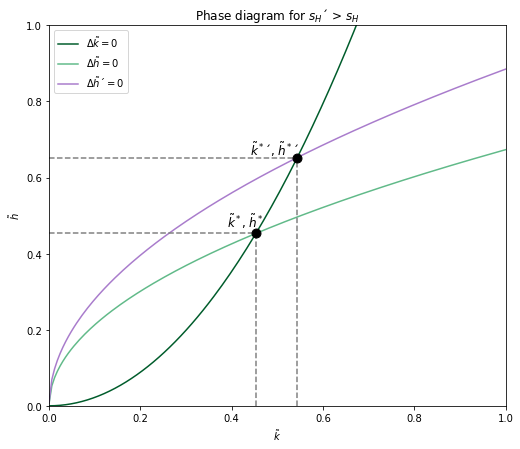

In [461]:
k_vec1,h_vec_DeltaK01, h_vec_DeltaH01 = solve_ss(0.12,sk,g,n,alpha,phi,delta)

analSolution2 = ss_func(0.12,sk,g,n,alpha,phi,delta)

#Create the plot
fig2 = plt.figure(figsize=(18,7))
ax = fig2.add_subplot(1,2,1)
ax.plot(k_vec,h_vec_DeltaK0, label=r'$\Delta \tilde{k}=0$', c='#005c2b')
ax.plot(k_vec,h_vec_DeltaH0, label=r'$\Delta \tilde{h}=0$', c='#61ba89')
ax.plot(k_vec1,h_vec_DeltaH01, label=r'$\Delta \tilde{h}´=0$', c='#a97ccc')
ax.set_xlabel(r'$\tilde{k}$')
ax.set_ylabel(r'$\tilde{h}$')
ax.legend()
plt.scatter(sol.x[1],sol.x[0],color='black',s=80,zorder=2.5) #We mark the first steady state
plt.scatter(analSolution2[0],analSolution2[1],color='black',s=80,zorder=2.5) #We mark the other steady state
plt.axvline(sol.x[1],ymax=0.45,color='gray',linestyle='--') #Line is drawn to mark the first ss-value on x-axis
plt.axhline(sol.x[0],xmax=0.45,color='gray',linestyle='--') #Line is drawn to mark the first ss-value on y-axis
plt.axvline(analSolution2[0],ymax=0.65,color='gray',linestyle='--') #Line is drawn to mark the other ss-value on x-axis
plt.axhline(analSolution2[1],xmax=0.55,color='gray',linestyle='--') #Line is drawn to mark the other ss-value on y-axis
ax.text(0.39, 0.47, r'$\tilde{k}^*, \tilde{h}^*$', fontsize=12) #Text is added to the plot
ax.text(0.44, 0.66, r'$\tilde{k}^*´, \tilde{h}^*$´', fontsize=12) #Text is added to the plot
ax.set(xlim=(0, 1), ylim=(0, 1)) #The axis values are chosen
ax.set_title('Phase diagram for $s_H$´ > $s_H$');

We know that $\tilde{y}_t^\ast=\tilde{k}_t^{\ast \alpha}\tilde{h}_t^{\ast \varphi}$

In [462]:
#We define the y steady state function
def y_ss(sh,sk,g,n,alpha,phi,delta):
    return ((sk**alpha*sh**(1-alpha))/(n+g+n*g+delta))**(alpha/(1-alpha-phi))*((sk**(1-phi)*sh**phi)/(n+g+n*g+delta))**(phi/(1-alpha-phi))

print(y_ss(sh,sk,g,n,alpha,phi,delta))

#We define the steady state function for c
def c_ss(sh,sk,g,n,alpha,phi,delta):
    return (1-sk-sh)*((sk**alpha*sh**(1-alpha))/(n+g+n*g+delta))**(alpha/(1-alpha-phi))*((sk**(1-phi)*sh**phi)/(n+g+n*g+delta))**(phi/(1-alpha-phi)
                                                                                                                                )

0.5898995047203758


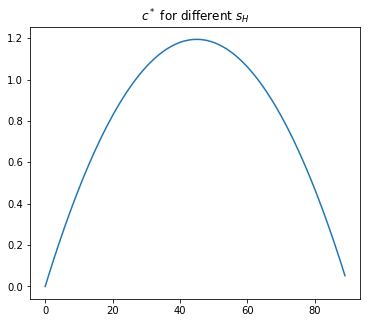

In [471]:
#We create a plot to show the variation in c when sh changes, all things equal

#we make an empty list to collect the differenc c-values
c_nums = []

for i in np.arange(0,0.9,0.01):
    c_nums.append(c_ss(i,sk,g,n,alpha,phi,delta))

fig = plt.figure(figsize=(13,5))
ax = fig.add_subplot(1,2,1)
ax.plot(c_nums)
ax.set_title('$c^*$ for different $s_H$');

In [464]:
print(max(c_nums))

maxc=max(c_nums)

x = sm.Symbol('x')
#c_diff = sm.diff((1-sk-x)*((sk**alpha*x**(1-alpha))/(n+g+n*g+delta))**(alpha/(1-alpha-phi))*((sk**(1-phi)*x**phi)/(n+g+n*g+delta))**(phi/(1-alpha-phi)),x)

1.1945464970587605


In [480]:
solve((1-sk-x)*((sk**alpha*x**(1-alpha))/(n+g+n*g+delta))**(alpha/(1-alpha-phi))*((sk**(1-phi)*x**phi)/(n+g+n*g+delta))**(phi/(1-alpha-phi))-maxc,x)

# Conclusion

HOMO = GODT